In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
from tensorflow.keras import metrics
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import tensorflow as tf
import cv2
import time

In [136]:
!ls /content/gdrive/'My Drive'/BrainTumorDataset/x_test.npy

'/content/gdrive/My Drive/BrainTumorDataset/x_test.npy'


In [137]:
model = load_model('/content/gdrive/My Drive/BrainTumorDataset/fft_model.h5')

In [0]:
x_test = np.load('/content/gdrive/My Drive/BrainTumorDataset/x_test.npy')
y_test = np.load('/content/gdrive/My Drive/BrainTumorDataset/y_test.npy')

In [0]:
weights = model.get_weights()

In [0]:
def zero_pad(img, pad):

    img_pad = np.pad(img, ((0,0), (pad, pad), (pad, pad), (0,0)), 'constant', constant_values = 0)
    return img_pad

In [0]:
def conv_single_step(a_slice_prev, W, b):

    s = np.sum(np.multiply(a_slice_prev, W)) + float(b)
    return s

In [0]:
def conv_forward(A_prev, W, b, hparameters):

    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape[0], A_prev.shape[1], A_prev.shape[2], A_prev.shape[3]
    
    
    (f, f, n_C_prev, n_C) = W.shape[0], W.shape[1], W.shape[2], W.shape[3]
    
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    n_H = int(((n_H_prev - f + (2 * pad)) / stride) + 1)
    n_W = int(((n_W_prev - f + (2 * pad)) / stride) + 1)
    
    Z = np.zeros((m, n_H, n_W, n_C))
    
    A_prev_pad = zero_pad(A_prev, pad)
    for i in range(m):                               
        a_prev_pad = A_prev_pad[i]  
        
        for h in range(n_H):                           
            for w in range(n_W):                       
                for c in range(n_C):                   
                    
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:,:,:,c], b[:,:,:,c])
                                        
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [0]:
def pool_forward(A_prev, hparameters, mode = "max"):

    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    A = np.zeros((m, n_H, n_W, n_C))              
    
    for i in range(m):                         
        for h in range(n_H):                   
            for w in range(n_W):               
                for c in range (n_C):          
                    
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    a_prev_slice = A_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    cache = (A_prev, hparameters)
    
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [0]:
def relu(X):
   return np.maximum(0,X)
def sigmoid(X):
   return 1/(1+np.exp(-X))

In [0]:
def conv_model(img, weights, hparameters1, hparameters2):
    conv = relu(conv_forward(img, weights[0], weights[1].reshape(1,1,1,weights[1].shape[0]), hparameters1)[0])
    pool = pool_forward(conv, hparameters2)[0]
    conv1 = relu(conv_forward(pool, weights[2], weights[3].reshape(1,1,1,weights[1].shape[0]), hparameters1)[0])
    pool1 = pool_forward(conv1, hparameters2)[0]
    conv2 = relu(conv_forward(pool1, weights[4], weights[5].reshape(1,1,1,weights[1].shape[0]), hparameters1)[0])
    pool2 = pool_forward(conv2, hparameters2)[0]
    flatten = pool2.reshape(1,pool2.shape[1]*pool2.shape[2]*pool2.shape[3])
    neural_net = relu(np.dot(flatten, weights[6]) + weights[7])
    ans = sigmoid(np.dot(neural_net, weights[8]) + weights[9])
    
    tup = (ans, conv, pool, conv1, pool1, conv2, pool2)
    return tup

In [0]:
def fft_forward(img,w, b, hparameters1):
    
    l = img.shape[1]
    pa = (l - 3) // 2
    f2 = np.pad(w.reshape(3,3), (pa,pa))
    img = img.reshape(l,l)
    
    if l % 2 == 0:
        l = l-1
        img = img[:l,:l]
        f = np.fft.fft2(img)
        f21 = np.fft.fft2(f2)
        aaa = f * f21
        final = np.fft.ifft2(aaa)
        
        zeros = np.zeros((l,l))
        zeros[1:l // 2+1,1:l // 2+1] = final.real[l // 2+1:,l // 2+1:]
        zeros[1:l // 2+1,l // 2+1:] = final.real[l // 2+1:,1:l // 2+1]
        zeros[l // 2+1:,1:l // 2+1] = final.real[1:l // 2+1,l // 2+1:]
        zeros[l // 2+1:,l // 2+1:] = final.real[1:l // 2+1,1:l // 2+1]

        zeros = zeros[1:l,1:l] + b

    else:
        f = np.fft.fft2(img)
        f21 = np.fft.fft2(f2)
        aaa = f * f21
        final = np.fft.ifft2(aaa)
    
        zeros = np.zeros((l,l))
        zeros[1:l // 2+1,1:l // 2+1] = final.real[l // 2+1:,l // 2+1:]
        zeros[1:l // 2+1,l // 2+1:] = final.real[l // 2+1:,1:l // 2+1]
        zeros[l // 2+1:,1:l // 2+1] = final.real[1:l // 2+1,l // 2+1:]
        zeros[l // 2+1:,l // 2+1:] = final.real[1:l // 2+1,1:l // 2+1]

        zeros = zeros[1:l-1,1:l-1] + b
    return zeros

In [0]:
def fft_model(img, weights, hparameters1, hparameters2):
    fft = relu(fft_forward(img, weights[0], weights[1], hparameters1))
    pool = pool_forward(fft.reshape(1,223,223,1), hparameters2)[0]
    fft1 = relu(fft_forward(pool, weights[2], weights[3], hparameters1))
    pool1 = pool_forward(fft1.reshape(1,fft1.shape[1],fft1.shape[1],1), hparameters2)[0]
    fft2 = relu(fft_forward(pool1, weights[4], weights[5], hparameters1))
    pool2 = pool_forward(fft2.reshape(1,fft2.shape[1],fft2.shape[1],1), hparameters2)[0]
    flatten = pool2.reshape(1,pool2.shape[1]*pool2.shape[2]*pool2.shape[3])
    neural_net = relu(np.dot(flatten, weights[6]) + weights[7])
    ans = sigmoid(np.dot(neural_net, weights[8]) + weights[9])
    
    tup = (ans, fft, pool, fft1, pool1, fft2, pool2)
    return tup

In [0]:
hparameters1 = {
    'stride':1,
    'pad':0
}
hparameters2 = {
    'stride':2,
    'f':2
}
weights = model.get_weights()

In [185]:
conv_out = []

start = time.time()
for i in range(len(x_test)):
  img = cv2.resize(x_test[i],(225,225)).reshape(1,225,225,1)
  output = conv_model(img, weights, hparameters1, hparameters2)
  if output[0] >= 0.5:
    conv_out.append(1)
  else:
    conv_out.append(0)

end = time.time()
  
print('Time taken by CNN to predict class for 253 images is', end - start)

Time taken by CNN to predict class for 253 images is 188.1543300151825


In [186]:
fft_out = []

start = time.time()
for i in range(len(x_test)):
  img = cv2.resize(x_test[i],(225,225)).reshape(1,225,225,1)
  output1 = fft_model(img, weights, hparameters1, hparameters2)
  if output1[0] >= 0.5:
    fft_out.append(1)
  else:
    fft_out.append(0)

end = time.time()
print('Time taken by FFT to predict class for 253 images is', end - start)  

Time taken by FFT to predict class for 253 images is 39.134761571884155


In [0]:
from sklearn.metrics import confusion_matrix

In [188]:
confusion_matrix(y_test, conv_out)

array([[ 65,  43],
       [ 10, 135]])

In [189]:
confusion_matrix(y_test, fft_out)

array([[ 54,  54],
       [ 20, 125]])

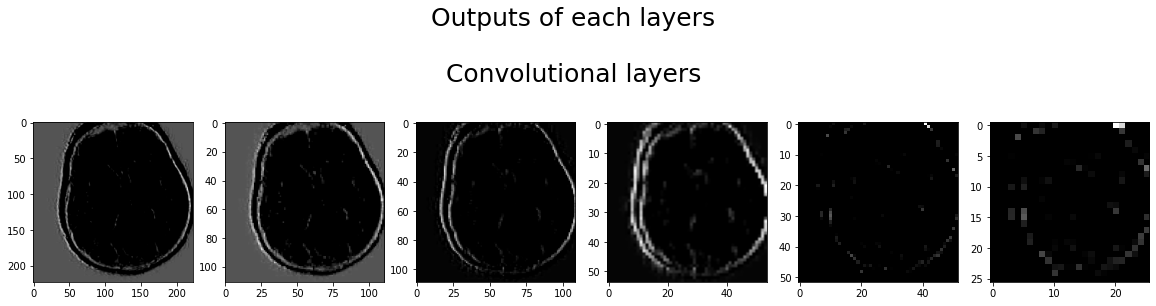

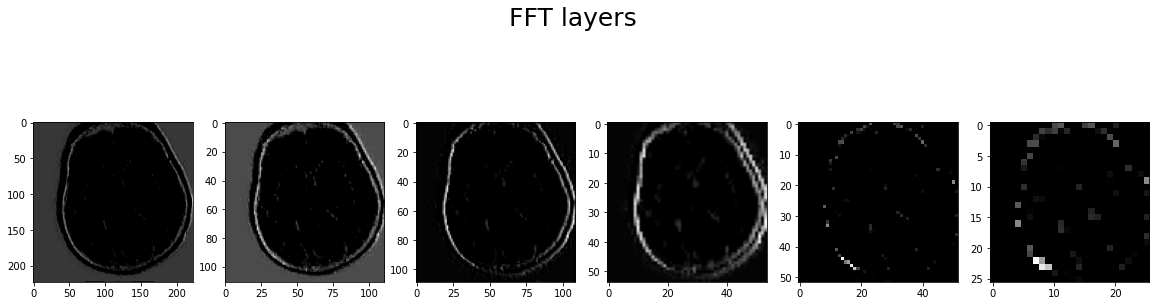

In [190]:
img = cv2.resize(x_test[15],(225,225)).reshape(1,225,225,1)  
output = conv_model(img, weights, hparameters1, hparameters2)
output1 = fft_model(img, weights, hparameters1, hparameters2)
categories = ['conv', 'fft']
for cat in categories:
  win=plt.figure(figsize=(20,10))
  if cat == 'conv':
    win.suptitle("Outputs of each layers\n\nConvolutional layers", fontsize=25)
  else:
    win.suptitle("FFT layers", fontsize=25) 
  index=1
  for i in range(1, len(output)):
      try:
          win.add_subplot(2,6,index) 
          if cat == 'fft':         
            plt.imshow(output1[i].reshape(output1[i].shape[1], output1[i].shape[1]), cmap='gray')
          else:
            plt.imshow(output[i].reshape(output[i].shape[1], output[i].shape[1]), cmap='gray')
          
          index=index+1
      except:
          break
  plt.show()